Coordinates of the cities are:
[(71,173), (66,48), (247,218), (104,156), (256,93), (165,34), (49,92), (107,198), (111,268), (99,73), (170,116), (271,259), (80,276), (186,193), (88,2), (30,128), (51,1), (138,27), (92,219), (257,155)]
Distance of initiallly randomly selected route: 2289.8693004387283
Route distance of final generations: 1158.9598818105676
Best Route is:
[(49,92), (30,128), (71,173), (104,156), (92,219), (80,276), (111,268), (107,198), (186,193), (247,218), (271,259), (257,155), (256,93), (170,116), (165,34), (138,27), (88,2), (51,1), (66,48), (99,73)]


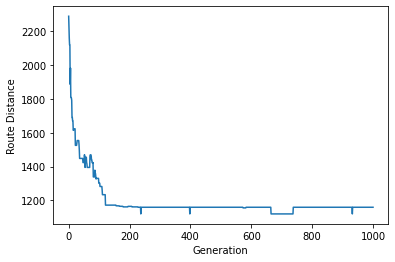

In [3]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt


class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"


class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            # Fitness will be inverse of the route distance
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness  # Higher the distance less will be it's fitness value


def createRoute(cityList):
    # Randomly select initial route to travel all the 20 cities for gujarat.
    route = random.sample(cityList, len(cityList))
    return route


def initialPopulation(popSize, cityList):
    population = []
    # Create number of routes for our population.
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


def rankRoutes(population):
    fitnessResults = {}
    for i in range(0, len(population)):
        # Calculate fitness value for each route in our population
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    # Assign key to each route
    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


# Slecting routes for crossover
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults


def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


# Creating new offsprings
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


# Genrating new poulation
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


# Function for mutation with very less probability
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            # Two randomly selected cities are swapped with aech other.
            individual[swapWith] = city1
    return individual


# Generating new population after mutaion
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


# Return the new generation which will go under the same process.
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Distance of initiallly randomly selected route: " +
          str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    print("Route distance of final generations: " +
          str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    print("Best Route is:")
    print(bestRoute)
    plt.plot(progress)
    plt.ylabel('Route Distance')
    plt.xlabel('Generation')
    plt.show()
    return bestRoute


def main():
    cityList = []
    # Randomly generate coordinates for 20 cities in 200 km sq. area.
    for i in range(0, 20):
        cityList.append(City(x=int(random.random() * 300),
                             y=int(random.random() * 300)))
    print("Coordinates of the cities are:")
    print(cityList)
    # generation- Upto how many generation we want to calculate the fitness value
    # popsize- number of routes for our population
    # mutationRate- propbaility of mutation
    # elitesize- number of best individuals which will be carried to next generation.

    geneticAlgorithm(population=cityList, popSize=100,
                     eliteSize=20, mutationRate=0.01, generations=1000)


if __name__ == "__main__":
    main()